# Acoustic modelling with Devito

This notebook showcases how to perform 2D acoustic modelling Devito.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from pylops.waveeqprocessing.mdd import MDD


## Geometry

In [ ]:
# parameters
inputfile = './data/pniose_for_cc_stacking.npz'
inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
dr = r[0, 1]-r[0, 0]
nr = r.shape[1]

# Sources
s = inputdata['s']
ds = s[1, 1]-s[1, 0]
ns = s.shape[1]

# models
vel = inputdata['vel']

# Axes
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

s = r
ns = nr
ds = dr

In [4]:
# data
GHG = np.load('./data/GHG_sum.npy')
GHd = np.load('./data/GHd_sum.npy')

print('the shape of p_withoutpd is', GHd.shape)
print('the shape of p is', GHG.shape)

the shape of p_withoutpd is (400, 400, 2999)
the shape of p is (400, 400, 2999)


In [5]:
nt = GHG.shape[2]
dt = 0.002
t = np.arange(nt) * dt

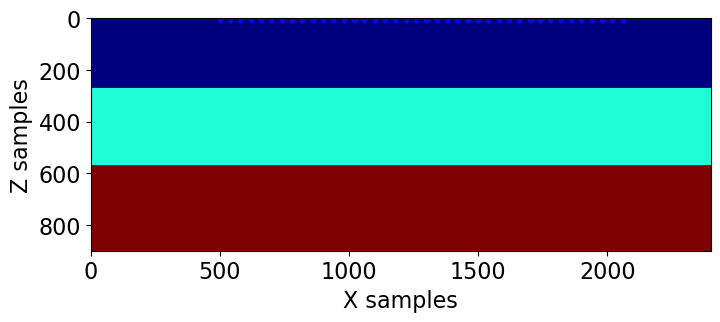

In [6]:
plt.figure(figsize=(8,8))
plot = plt.imshow(vel,cmap='jet',origin='upper',extent = (x[0], x[-1], z[-1], z[0]))
plt.xlabel("X samples")
plt.ylabel("Z samples")
plt.scatter(s[0, 0::10], s[1, 0::10], marker='o', s=5, c='r')
plt.scatter(r[0, 0::10],  r[1, 0::10], marker='v', s=20, c='b')

plt.show()

## MDD

In [ ]:
# normalize the data
p_withoutpd = GHd
p = GHG
del GHG, GHd

nfmax = 1500
scaling = p.max()
p_withoutpd /= scaling
p /= scaling

(500.0, 2096.0, 2.998, 0.0)

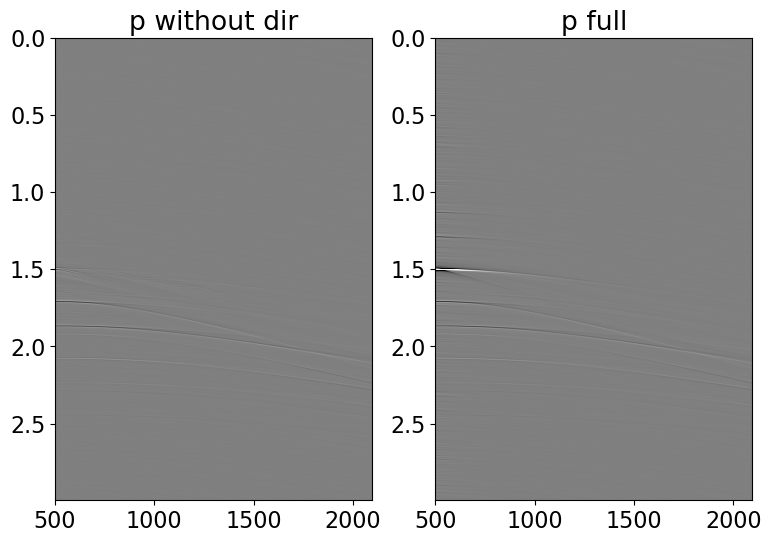

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p_withoutpd[0].T, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('p without dir')
axs[0].axis('tight')
# axs[0].set_ylim(2.922, 0)
axs[1].imshow(p[0].T, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('p full')
axs[1].axis('tight')
# axs[1].set_ylim(2.922, 0)

In [21]:
# Invert for model (MDD) shape is (ns,nr,nt)
Rinv,Radj = MDD(p, p_withoutpd, dt=dt, dr=dr, 
                nfmax=nfmax, twosided=True, add_negative=True,
                adjoint=True, psf=False, dottest=False, 
                **dict(damp=1e-10, iter_lim=20, show=1))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 479840000 rows and 479840000 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.401e+01  2.401e+01    1.0e+00  5.4e-01
     1 -2.65034e-08   1.880e+01  1.880e+01    7.8e-01  6.4e-01   2.1e+01  1.0e+00
     2 -9.08376e-07   1.482e+01  1.482e+01    6.2e-01  3.9e-01   3.4e+01  2.6e+00
     3 -5.67099e-06   1.249e+01  1.249e+01    5.2e-01  2.5e-01   4.6e+01  4.4e+00
     4  2.00959e-05   1.066e+01  1.066e+01    4.4e-01  2.0e-01   5.4e+01  6.2e+00
     5 -1.11598e-05   9.283e+00  9.283e+00    3.9e-01  1.6e-01   6.1e+01  8.2e+00
     6  5.39246e-06   8.192e+00  8.192e+00    3.4e-01  1.3e-01   6.7e+01  1.0e+01
     7 -1.07472e-06   7.400e+00  7.400e+00    3.1e-01  1.2e-01   7.2e+01  1.2e+01
     8 -6.06085e-06   6.

(1300.0, 2096.0, 2.998, 0.0)

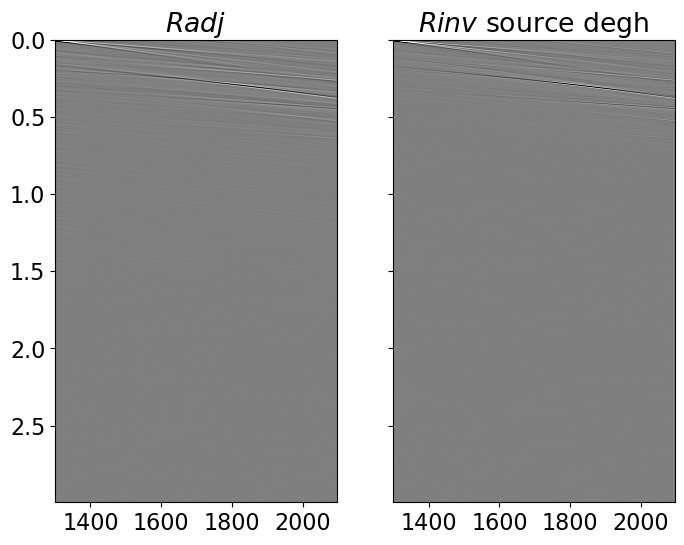

In [ ]:
clip = 0.1
clipR = 0.1
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,6))
axs[0].imshow(Radj[nr//2,nr//2:,nt-1:].T, cmap='gray', vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (r[0,nr//2], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv[nr//2,nr//2:,nt-1:].T, cmap='gray', vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
              extent = (r[0,nr//2], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$ source degh')
axs[1].axis('tight')
# axs[2].imshow(R, cmap='gray', vmin=-clipR*np.abs(R).max(), vmax=clipR*np.abs(R).max(),
#               extent = (0, 1200, 4, 0))
# axs[2].set_title(r'$Rtrue$ (without direct wave)')
# axs[2].axis('tight')
# axs[2].set_ylim(2., 0);

In [ ]:
np.save('data/Radj_3min_nowav', p_withoutpd[...,nt-1:])
np.save('data/Rinv_3min_nowav', Rinv[...,nt-1:])